In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn import datasets
sess = tf.Session()

In [2]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import seaborn as sns

from scipy import ndimage
from subprocess import check_output

import cv2


pal = sns.color_palette()

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [3]:
iris = datasets.load_iris()
x_vals = np.array([[x[0], x[3]] for x in iris.data])
y_vals = np.array([1 if y==0 else -1 for y in iris.target])
class1_x = [x[0] for i,x in enumerate(x_vals) if
y_vals[i]==1]
class1_y = [x[1] for i,x in enumerate(x_vals) if
y_vals[i]==1]
class2_x = [x[0] for i,x in enumerate(x_vals) if
y_vals[i]==-1]
class2_y = [x[1] for i,x in enumerate(x_vals) if
y_vals[i]==-1]

In [4]:
batch_size = 100
x_data = tf.placeholder(shape=[None, 2], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)
prediction_grid = tf.placeholder(shape=[None, 2],
dtype=tf.float32)
b = tf.Variable(tf.random_normal(shape=[1,batch_size]))

In [5]:
gamma = tf.constant(-10.0) # feel free to explore different values of gamma 
dist = tf.reduce_sum(tf.square(x_data), 1)
dist = tf.reshape(dist, [-1,1])
sq_dists = tf.add(tf.subtract(dist, tf.multiply(2., tf.matmul(x_data,
tf.transpose(x_data)))), tf.transpose(dist))
my_kernel = tf.exp(tf.multiply(gamma, tf.abs(sq_dists)))
#We now compute the loss for the dual optimization problem, as follows:
model_output = tf.matmul(b, my_kernel)
first_term = tf.reduce_sum(b)
b_vec_cross = tf.matmul(tf.transpose(b), b)
y_target_cross = tf.matmul(y_target, tf.transpose(y_target))
second_term = tf.reduce_sum(tf.multiply(my_kernel,
tf.multiply(b_vec_cross, y_target_cross)))
loss = tf.negative(tf.subtract(first_term, second_term))

In [6]:
rA = tf.reshape(tf.reduce_sum(tf.square(x_data), 1),[-1,1])
rB = tf.reshape(tf.reduce_sum(tf.square(prediction_grid), 1),
[-1,1])
pred_sq_dist = tf.add(tf.subtract(rA, tf.multiply(2., tf.matmul(x_data,
tf.transpose(prediction_grid)))), tf.transpose(rB))

In [7]:
pred_kernel = tf.exp(tf.multiply(gamma, tf.abs(pred_sq_dist)))
prediction_output =tf.matmul(tf.multiply(tf.transpose(y_target),b), pred_kernel)

In [8]:
prediction = tf.sign(prediction_output-tf.reduce_mean(prediction_output))

In [9]:
accuracy =tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(prediction),tf.squeeze(y_target)), tf.float32))

In [10]:
my_opt = tf.train.GradientDescentOptimizer(0.01)
train_step = my_opt.minimize(loss)
init = tf.global_variables_initializer() # this line is different depending on your version of tf
sess.run(init)

In [11]:
loss_vec = []
batch_accuracy = []
for i in range(300):
    rand_index = np.random.choice(len(x_vals),size=batch_size)
    rand_x = x_vals[rand_index]
    rand_y = np.transpose([y_vals[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target:rand_y})
    temp_loss = sess.run(loss, feed_dict={x_data: rand_x,y_target: rand_y})
    loss_vec.append(temp_loss)
    acc_temp = sess.run(accuracy, feed_dict={x_data: rand_x,y_target:rand_y,prediction_grid:rand_x})
    batch_accuracy.append(acc_temp)

In [12]:
x_min, x_max = x_vals[:, 0].min() - 1, x_vals[:, 0].max() + 1
y_min, y_max = x_vals[:, 1].min() - 1, x_vals[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),np.arange(y_min, y_max, 0.02))
grid_points = np.c_[xx.ravel(), yy.ravel()]
[grid_predictions] = sess.run(prediction, feed_dict={x_data:rand_x,y_target:rand_y,prediction_grid: grid_points})
grid_predictions = grid_predictions.reshape(xx.shape)

/home/ldp/.local/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning:

In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.

/home/ldp/.local/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning:

In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.



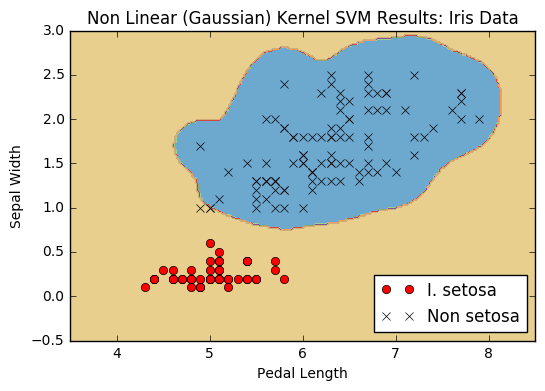

In [13]:
plt.contourf(xx, yy, grid_predictions, cmap=plt.cm.Paired,　alpha=0.8)
plt.plot(class1_x, class1_y, 'ro', label='I. setosa')
plt.plot(class2_x, class2_y, 'kx', label='Non setosa')
plt.title('Non Linear (Gaussian) Kernel SVM Results: Iris Data')
plt.xlabel('Pedal Length')
plt.ylabel('Sepal Width')
plt.legend(loc='lower right')
plt.ylim([-0.5, 3.0])
plt.xlim([3.5, 8.5])
plt.show()

In [14]:
iris = datasets.load_iris()
x_vals = np.array([[x[0], x[3]] for x in iris.data])
y_vals1 = np.array([1 if y==0 else -1 for y in iris.target])
y_vals2 = np.array([1 if y==1 else -1 for y in iris.target])
y_vals3 = np.array([1 if y==2 else -1 for y in iris.target])
y_vals = np.array([y_vals1, y_vals2, y_vals3])
class1_x = [x[0] for i,x in enumerate(x_vals) if
iris.target[i]==0]
class1_y = [x[1] for i,x in enumerate(x_vals) if
iris.target[i]==0]
class2_x = [x[0] for i,x in enumerate(x_vals) if
iris.target[i]==1]
class2_y = [x[1] for i,x in enumerate(x_vals) if
iris.target[i]==1]
class3_x = [x[0] for i,x in enumerate(x_vals) if
iris.target[i]==2]
class3_y = [x[1] for i,x in enumerate(x_vals) if
iris.target[i]==2]

In [15]:
batch_size = 50
x_data = tf.placeholder(shape=[None, 2], dtype=tf.float32)
y_target = tf.placeholder(shape=[3, None], dtype=tf.float32)
prediction_grid = tf.placeholder(shape=[None, 2],dtype=tf.float32)
b = tf.Variable(tf.random_normal(shape=[3,batch_size]))

In [16]:
gamma = tf.constant(-1.0) 
dist = tf.reduce_sum(tf.square(x_data), 1)
dist = tf.reshape(dist, [-1,1])
sq_dists = tf.add(tf.subtract(dist, tf.multiply(2., tf.matmul(x_data,tf.transpose(x_data)))), tf.transpose(dist))
my_kernel = tf.exp(tf.multiply(gamma, tf.abs(sq_dists)))

In [17]:
#batch multiplication
def reshape_matmul(mat):
    v1 = tf.expand_dims(mat, 1)
    v2 = tf.reshape(v1, [3, batch_size, 1])
    return(tf.matmul(v2, v1))

In [18]:
#loss
model_output = tf.matmul(b, my_kernel)
first_term = tf.reduce_sum(b)
b_vec_cross = tf.matmul(tf.transpose(b), b)
y_target_cross = reshape_matmul(y_target)
second_term = tf.reduce_sum(tf.multiply(my_kernel,tf.multiply(b_vec_cross, y_target_cross)),[1,2])
loss = tf.reduce_sum(tf.negative(tf.subtract(first_term, second_term)))

In [19]:
rA = tf.reshape(tf.reduce_sum(tf.square(x_data), 1),[-1,1])
rB = tf.reshape(tf.reduce_sum(tf.square(prediction_grid), 1),[-1,1])

pred_sq_dist = tf.add(tf.subtract(rA, tf.multiply(2., tf.matmul(x_data,tf.transpose(prediction_grid)))), tf.transpose(rB))
pred_kernel = tf.exp(tf.multiply(gamma, tf.abs(pred_sq_dist)))

In [20]:
prediction_output = tf.matmul(tf.multiply(y_target,b),pred_kernel)
prediction = tf.arg_max(prediction_output-tf.expand_dims(tf.reduce_mean(prediction_output,1), 1), 0)
accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction,tf.argmax(y_target,0)), tf.float32))

In [21]:
my_opt = tf.train.GradientDescentOptimizer(0.01)
train_step = my_opt.minimize(loss)
init = tf.global_variables_initializer()
sess.run(init)

In [22]:
loss_vec = []
batch_accuracy = []

In [23]:
for i in range(1000):
    rand_index = np.random.choice(len(x_vals),
    size=batch_size)
    rand_x = x_vals[rand_index]
    rand_y = y_vals[:,rand_index]
    sess.run(train_step, feed_dict={x_data: rand_x, y_target:rand_y})
    temp_loss = sess.run(loss, feed_dict={x_data: rand_x,y_target: rand_y})
    loss_vec.append(temp_loss)
    acc_temp = sess.run(accuracy, feed_dict={x_data: rand_x,y_target: rand_y, prediction_grid:rand_x})
    batch_accuracy.append(acc_temp)
    if (i+1)%5==0:
        print('Step #' + str(i+1))
        print('Loss = ' + str(temp_loss))

Step #5
Loss = 42.634
Step #10
Loss = 27.2177
Step #15
Loss = 17.9595
Step #20
Loss = 8.25513
Step #25
Loss = -0.337186
Step #30
Loss = -11.1627
Step #35
Loss = -5.71995
Step #40
Loss = -7.55356
Step #45
Loss = -8.99611
Step #50
Loss = -9.5577
Step #55
Loss = -10.7482
Step #60
Loss = -10.5681
Step #65
Loss = -11.8732
Step #70
Loss = -13.1309
Step #75
Loss = -11.8064
Step #80
Loss = -13.0734
Step #85
Loss = -11.4097
Step #90
Loss = -12.02
Step #95
Loss = -12.3009
Step #100
Loss = -12.1006
Step #105
Loss = -11.093
Step #110
Loss = -12.4669
Step #115
Loss = -13.0574
Step #120
Loss = -12.3656
Step #125
Loss = -12.1467
Step #130
Loss = -12.0563
Step #135
Loss = -11.9701
Step #140
Loss = -13.2737
Step #145
Loss = -13.2944
Step #150
Loss = -11.9458
Step #155
Loss = -10.827
Step #160
Loss = -13.4344
Step #165
Loss = -11.4478
Step #170
Loss = -13.1337
Step #175
Loss = -12.7893
Step #180
Loss = -11.3913
Step #185
Loss = -13.3639
Step #190
Loss = -11.4933
Step #195
Loss = -14.1915
Step #200
Loss 